## Feature selection: finding distinctive words

### Step 1: Calculate the rate for each word in each document with the rate of 1000 words.

We often want to know what words distinguish one group of texts from another group of texts. For instance, we might be working with an archive of two city newspapers, say, the Frankfurter Allgemeine Zeitung and the Frankfurter Rundschau and want to know which words tend to appear in one newspaper rather than the other. Or we might be interested in comparing word usage in US Presidents’ State of the Union addresses given during recessions with addresses given during periods of economic growth. Or we might be comparing the style of several novelists and want to know if one author tends to use words not found in the works of others.

This section illustrates how distinctive words can be identified using a corpus of novels containing works by two authors: Jane Austen and Charlotte Brontë.

Austen, Emma
Austen, Pride and Prejudice
Austen, Sense and Sensibility
C. Brontë, Jane Eyre
C. Brontë, The Professor
C. Brontë, Villette

In [1]:
import os
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

This corpus of six novels consists of the following text files:

In [2]:
filenames = ['Austen_Emma.txt',
 'Austen_Pride.txt',
 'Austen_Sense.txt',
 'CBronte_Jane.txt',
 'CBronte_Professor.txt',
 'CBronte_Villette.txt']

In [3]:
filenames_with_path = [os.path.join('data/austen-brontë/', fn) for fn in filenames]

In [4]:
filenames_with_path

['data/austen-brontë/Austen_Emma.txt',
 'data/austen-brontë/Austen_Pride.txt',
 'data/austen-brontë/Austen_Sense.txt',
 'data/austen-brontë/CBronte_Jane.txt',
 'data/austen-brontë/CBronte_Professor.txt',
 'data/austen-brontë/CBronte_Villette.txt']

Since we are concerned with words, we begin by extracting word frequencies from each of the texts in our corpus and construct a document-term matrix that records the rate per 1,000 words for each word appearing in the corpus. Using rates rather than counts will allow us to account for differences in the length of the novels. Accounting for differences in document lengths when dealing with word counts is essential. For example, a text using “whence” ten times in a 1,000 word article uses the word at a rate of 10 per 1,000 words, while a 100,000 word novel that uses “whence” 20 times uses it at a rate of 0.2 per 1,000 words. While the word occurs more in absolute terms in the second text, the rate is higher in the first text. While there are other ways to account for document length—a procedure called “normalization”—considering the rate per 1,000 words will serve us well. An appealing feature of word rates per 1,000 words is that readers are familiar with documents of this length (e.g., a newspaper article).

In [15]:
#these texts have underscores ('_') that indicate italics; remove them.
raw_texts = []
for fn in filenames_with_path:
    with open(fn) as f:
        text = f.read()
        text = text.replace('_', '')  # remove underscores (italics)
        raw_texts.append(text)

In [6]:
vectorizer = CountVectorizer(input='content')

In [7]:
# This creates a document term matrix using the CountVectorizer Method
dtm = vectorizer.fit_transform(raw_texts)

In [29]:
vocab = np.array(vectorizer.get_feature_names())

#### Why does Count Vectorizer return a Sparse Matrix and what is a Sparse Matrix?

A sparse matrix only records non-zero entries and is used to store matrices that contain a significant number of entries that are zero. To understand why this matters enough that CountVectorizer returns a sparse matrix by default, consider a 4000 by 50000 matrix of word frequencies that is 60% zeros. In Python an integer takes up four bytes, so using a sparse matrix saves almost 500M of memory, which is a considerable amount of computer memory in the 2010s.

In [9]:
# fit_transform returns a sparse matrix (which uses less memory)
# but we want to work with a normal numpy array.
dtm = dtm.toarray()

In [31]:
# normalize counts to rates per 1000 words
rates = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True)

In [32]:
# just examine a sample, those at offsets 100 to 105
rates[:,100:105]

array([[ 0.        ,  0.00646634,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.01189641,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.00541237,  0.00541237,  0.00541237]])

In [33]:
vocab[100:105]

array(['abdiel', 'abdy', 'abed', 'aberdeen', 'aberration'],
      dtype='<U20')

In [49]:
# In order to find how many times the word "house" appeared in the first document
house_idx = list(vocab).index('house')
dtm[0,house_idx]

95

### Comparing Texts using Euclidean Distance & Cosine Similarity

reference: https://de.dariah.eu/tatom/working_with_text.html#working-with-text

##### 1. Euclidean Distance

The Euclidean distance between two vectors in the plane should be familiar from geometry, as it is the length of the hypotenuse that joins the two vectors. For instance, consider the Euclidean distance between the vectors x→=(1,3) and y→=(4,2). The distance between the two vectors is √(1−4)2+(3−2)2=√10.

This two dimension thing can be extended to an arbitrary number of dimensions.Since two novels in our corpus now have an expression as vectors, we can calculate the Euclidean distance between them.

In [51]:
from sklearn.metrics.pairwise import euclidean_distances

dist = euclidean_distances(dtm)

np.round(dist,1)

array([[    0. ,  3875.3,  4204.1,  5120.8,  7139.6,  5285.3],
       [ 3875.3,     0. ,  1924.1,  6310.6,  4128.4,  6399.5],
       [ 4204.1,  1924.1,     0. ,  6657.4,  4045.3,  6671.9],
       [ 5120.8,  6310.6,  6657.4,     0. ,  8363.8,  2580.5],
       [ 7139.6,  4128.4,  4045.3,  8363.8,     0. ,  8512.3],
       [ 5285.3,  6399.5,  6671.9,  2580.5,  8512.3,     0. ]])

In [52]:
# the distance between the first and third document can be calculated as 

dist[1,3]

6310.634199508002

In [53]:
# the distance between the third and fifth document can be calculated as 
dist[3,5]

2580.5425786062901

Which shows the third and fifth documents have more similarity as compared to the first and third documents.

#### 2. Cosine Similarity

If we want to use a measure of distance that takes into consideration the length of the novels, we could use cosine similarity.This uses the judgement of orientation for similarity between two vector spaces.Two vectors with the same orientation have a cosine similarity of 1, two vectors at 90° have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude. 

In [54]:
from sklearn.metrics.pairwise import cosine_similarity

dist = cosine_similarity(dtm)

dist[1,3]

0.95300895444272904

In [55]:
dist[3,5]

0.98648980805771291

###  Visualizing Distances

It is often desirable to visualize the pairwise distances between our texts. A general approach to visualizing distances is to assign a point in a plane to each text, making sure that the distance between points is proportional to the pairwise distances we calculated. This kind of visualization is common enough that it has a name, “multidimensional scaling” (MDS) and family of functions in scikit-learn

In [56]:
import os
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity = "precomputed",random_state = 1)
pos = mds.fit_transform(dist)

In [61]:
pos

array([[ 0.30512421,  0.50148218],
       [-0.31118147, -0.53997537],
       [-0.30294241,  0.52400592],
       [-0.58846552,  0.01397593],
       [ 0.61372252,  0.00472299],
       [ 0.28374266, -0.50421165]])

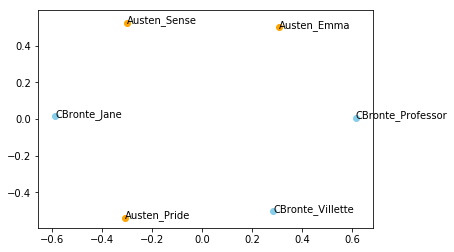

In [62]:
xs, ys = pos[:, 0], pos[:, 1]
# Short version of filenames
names = [os.path.basename(fn).replace('.txt', '') for fn in filenames]
for x, y, name in zip(xs, ys, names):
    color = 'orange' if "Austen" in name else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, name)

plt.show()

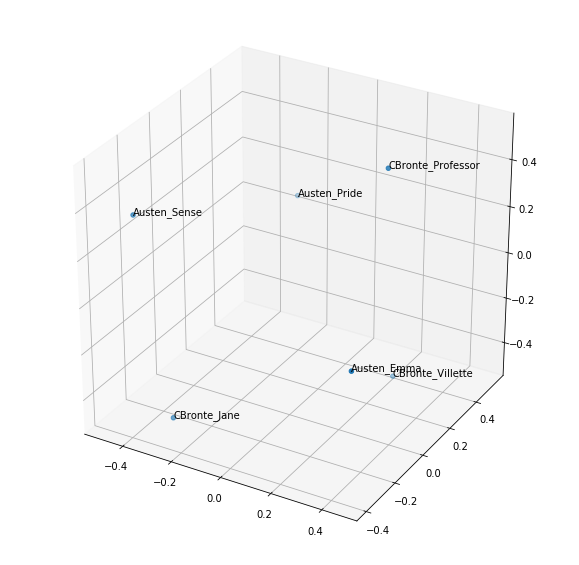

In [67]:
## Three Dimensions
from mpl_toolkits.mplot3d import Axes3D

mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])

for x, y, z, s in zip(pos[:, 0], pos[:, 1], pos[:, 2], names):
    ax.text(x, y, z, s)
    
plt.show()

### Clustering texts based on distance

Any clustering of texts should result in texts that are closer to each other (in the distance matrix) residing in the same cluster. There are many ways of satisfying this requirement; there no unique clustering based on distances that is the “best”. One strategy for clustering in circulation is called Ward’s method. Rather than producing a single clustering, Ward’s method produces a hierarchy of clusterings.

Ward Clustering:

1. Start with each text in its own cluster
2. Until only a single cluster remains,Find the closest clusters and merge them. The distance between two clusters is the change in the sum of squared distances when they are merged.
3. Return a tree containing a record of cluster-merges.

In [76]:
from scipy.cluster.hierarchy import ward,dendrogram

linkage_matrix = ward(dist)

dendrogram(linkage_matrix,orientation="left",labels=names)

{'color_list': ['g', 'g', 'r', 'r', 'b'],
 'dcoord': [[0.0, 0.016443047287912363, 0.016443047287912363, 0.0],
  [0.0, 0.025373089374746874, 0.025373089374746874, 0.016443047287912363],
  [0.0, 0.026717588243159944, 0.026717588243159944, 0.0],
  [0.0, 0.040065971472620671, 0.040065971472620671, 0.026717588243159944],
  [0.025373089374746874,
   0.16539003002465538,
   0.16539003002465538,
   0.040065971472620671]],
 'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [12.5, 12.5, 42.5, 42.5]],
 'ivl': ['CBronte_Jane',
  'CBronte_Professor',
  'CBronte_Villette',
  'Austen_Emma',
  'Austen_Pride',
  'Austen_Sense'],
 'leaves': [3, 4, 5, 0, 1, 2]}

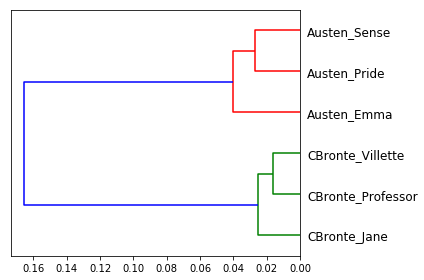

In [77]:
plt.tight_layout()
plt.show()